In [20]:
### Code based on "Planning for Autonomous Cars that Leverage Effects on Human Actions" ###

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint

In [33]:
### Create a class to perform the nested optimization ###

class Influence(object):

    def __init__(self):

        # initialize autonomous car
        self.n_robot_actions = 5
        self.robot_actions_0 = np.array([0.0]*self.n_robot_actions)
        self.xi_r = np.zeros((6,2))

        # initialize human car
        self.n_human_actions = 5
        self.human_actions_0 = np.array([0.0]*self.n_human_actions)
        self.xi_h = np.zeros((6,2))

        # create action constraint
        self.nonlincon = NonlinearConstraint(self.nl_function, -1.0, 1.0)

    # each action cannot move more than 1 unit
    def nl_function(self, actions):
        return actions

    # autonomous vehicle dynamics
    # the autonomous car moves up and down
    def robot_dynamics(self, robot_actions):
        car_position = np.array([0., 0.])
        self.xi_r[0, :] = np.copy(car_position)
        for idx, a_r in enumerate(robot_actions):
          car_position[1] += a_r
          self.xi_r[idx+1, :] = np.copy(car_position)
          
    # human vehicle dynamics
    # the human car moves left and right
    def human_dynamics(self, human_actions):
        car_position = np.array([-2., 2.])
        self.xi_h[0, :] = np.copy(car_position)
        for idx, a_h in enumerate(human_actions):
          car_position[0] += a_h
          self.xi_h[idx+1, :] = np.copy(car_position)

    # human cost function
    def human_cost(self, human_actions):
        self.human_dynamics(human_actions)
        cost = 0.0
        for idx in range(len(self.xi_h)):
          robot_position = self.xi_r[idx,:]
          human_position = self.xi_h[idx,:]
          ### the human wants to avoid collision ###
          cost += np.exp(-np.linalg.norm(human_position - robot_position)) * 100
          ### the human wants to cross the street ###
          cost += 5 - human_position[0]
        return cost

    # robot cost function
    def robot_cost(self, robot_actions):
        self.robot_dynamics(robot_actions)
        res = minimize(self.human_cost, self.human_actions_0, method='SLSQP', constraints=self.nonlincon, options={'eps': 1e-3, 'maxiter': 1000})
        cost = 0.0
        for idx in range(len(self.xi_r)):
          robot_position = self.xi_r[idx,:]
          human_position = self.xi_h[idx,:]
          ### the autonomous car wants to let the human go first ###
          cost += 5 - human_position[0]
        ### the autonomous car wants to minimize its effort ###
        cost += np.sum(np.abs(robot_actions)) * 1
        return cost

    # run the optimizer
    def optimize(self):
        res = minimize(self.robot_cost, self.robot_actions_0, method='SLSQP', constraints=self.nonlincon, options={'eps': 1e-3, 'maxiter': 1000})
        return res.x, res

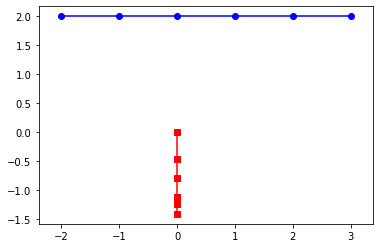

In [34]:
### Run and plot the results ###
### if you play with the weights for each reward, you will see different behaviors ###

game = Influence()
robot_actions, res = game.optimize()
xi_r = game.xi_r
xi_h = game.xi_h
plt.plot(xi_r[:,0], xi_r[:,1], 'rs-') # autonomous car is in red
plt.plot(xi_h[:,0], xi_h[:,1], 'bo-') # human car is in blue
plt.axis("equal")
plt.show()